<a href="https://colab.research.google.com/github/Preranakh/800LevelProject/blob/TestBranch/MNIST_badnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ssh-keygen -t rsa -b 4096

Generating public/private rsa key pair.
Enter file in which to save the key (/root/.ssh/id_rsa): 
Created directory '/root/.ssh'.
Enter passphrase (empty for no passphrase): 
Enter same passphrase again: 
Your identification has been saved in /root/.ssh/id_rsa.
Your public key has been saved in /root/.ssh/id_rsa.pub.
The key fingerprint is:
SHA256:c4Hj5i4hxXxoUKW45U6dyTmUStC1C8nLEUL3bVxcroI root@9eaf3e7de6e3
The key's randomart image is:
+---[RSA 4096]----+
|   .+o+oo  ....  |
|    .*.= * ...   |
|    .+O.B =   .  |
|     **X.O . .   |
|    .o*.E o .    |
|    .o.o + .     |
|     ....        |
|      ..         |
|       ..        |
+----[SHA256]-----+


In [2]:
!ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts

# github.com:22 SSH-2.0-babeld-2aa8e17d


In [3]:
!cat /root/.ssh/id_rsa.pub

ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAACAQCaUnSUf/GfRKBEwXMvNwj46dM8z0GzxiPhQ8+SDBBXYvRL77VNQwnNzUg389lrXtM6TkmLndPcajsZn8zuRSq2FxVDnMrE0yRZ3nDIPLOyHMWUkbBy6FMXbPzRAxlAAugTTkTbaPqvshO1KlknrnMILDN2KyvbGBQZkDtk2wOlTIj6nzOOeruCJV+iya5/PCF8TfUwfBij60uUpIf0wiMwzNYUmTQpvbgLGSViJC/lmOiHEIUB9LCJnalMKe3J7dFlwE+Jp5XtAV2s3s2FwWQdrtv34xHIPESjlHntJKpqSTV0LR4MMDfiWtWrzBAgfzmWVlaJ80ij0h52qRzBOWdFbWMAQKW7c8+fLJKb0ufKuSPCarxdgwrancYxkX2ECqOKbYTZo6FmYcO7ElHwv4zKHK6Lf8L1mXZypl3K2vF1yKpzWZVto4dhYc9Rd2h6VRyP4ZEQXIY39eZhl19vQEuvP03NMKYhFPSu4uYYfLFWJK+UaOxiAh0xuM3mSkAtMv/x3cUrkkWbsQmQy9pCeFJzSl/Pj/DlN8wLQmVgff7iliYsJDFD/38w2BvZfLzo3Z2YMdhCzHtbMrPdV9iT0s4Fugd2tNRm5AG06w7ppAM/NSfuMZvEybGxoxw56RCBjuwtgIihYCts77dualHNNwQ2vXc45KCV8H39kjOf9KeLpw== root@9eaf3e7de6e3


In [4]:
!ssh -T git@github.com

Hi Preranakh! You've successfully authenticated, but GitHub does not provide shell access.


In [5]:
!git config --global user.email "khatiwadaprerana@gmail.com"

In [6]:
!git config --global user.name "Preranakh"

In [7]:
!git clone git@github.com:Preranakh/Advanced-Topics-in-Computer-Applications-Project.git

Cloning into 'Advanced-Topics-in-Computer-Applications-Project'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 126 (delta 15), reused 0 (delta 0), pack-reused 93
Receiving objects: 100% (126/126), 47.93 MiB | 15.18 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [8]:
%cp -r Advanced-Topics-in-Computer-Applications-Project/src .

In [9]:
%rm -rf Advanced-Topics-in-Computer-Applications-Project

In [10]:
!pip3 install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 13.6 MB/s 


In [11]:
!pip3 install adversarial-robustness-toolbox tensorflow Keras matplotlib ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 15.7 MB/s 


In [12]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')

In [13]:
# Disable TensorFlow eager execution:
import tensorflow as tf
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()

import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

In [14]:
from src.classifiers.kerasclassifier import KerasClassifier
from src.attacks.backdoor import PoisoningAttackBackdoor
from src.attacks.utils import pattern_backdoor, single_backdoor, insert_image
from src.preprocessing.utils import load_mnist, preprocess

In [15]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 10000
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

BACKDOOR_TYPE = "pattern" # one of ['pattern', 'pixel', 'image']

In [16]:
max_val = np.max(x_raw)
def add_modification(x):
        if BACKDOOR_TYPE == 'pattern':
            return pattern_backdoor(x, pixel_value=max_val)
        elif BACKDOOR_TYPE == 'pixel':
            return single_backdoor(x, pixel_value=max_val) 
        elif BACKDOOR_TYPE == 'image':
            return insert_image(x, backdoor_path='../utils/data/backdoors/alert.png', size=(10,10))
        else:
            raise("Unknown backdoor type")

In [17]:
def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))
    
    sources=np.arange(10) # 0, 1, 2, 3, ...
    targets=(np.arange(10) + 1) % 10 # 1, 2, 3, 4, ...
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        backdoor_attack = PoisoningAttackBackdoor(poison_func)
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned, y=np.ones(num_poison) * tgt)
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, x_poison, y_poison

In [18]:
# Poison training data
percent_poison = .1
(is_poison_train, x_poisoned_raw, y_poisoned_raw) = poison_dataset(x_raw, y_raw, percent_poison, add_modification)
x_train, y_train = preprocess(x_poisoned_raw, y_poisoned_raw)
# Add channel axis:
x_train = np.expand_dims(x_train, axis=3)

# Poison test data
(is_poison_test, x_poisoned_raw_test, y_poisoned_raw_test) = poison_dataset(x_raw_test, y_raw_test, percent_poison, add_modification)
x_test, y_test = preprocess(x_poisoned_raw_test, y_poisoned_raw_test)
# Add channel axis:
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

In [19]:
x_train.shape[1:]

(28, 28, 1)

In [20]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
from src import constants
from src.classifiers.kerasclassifier import KerasClassifier
from src.attacks.fast_gradient import FastGradientMethod
from src.defences.adversarial_trainer import AdversarialTrainer

import numpy as np

# %matplotlib inline
import matplotlib.pyplot as plt

In [22]:
from src.attacks.projected_gradient_descent import ProjectedGradientDescent

robust_classifier = KerasClassifier(model)

attacks = ProjectedGradientDescent(robust_classifier, eps=0.3, eps_step=0.01, max_iter=40)

trainer = AdversarialTrainer(robust_classifier, attacks, ratio=1.0)
trainer.fit(x_train, y_train, nb_epochs=20, batch_size=250)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/20 [00:00<?, ?it/s]

src.classifiers.kerasclassifier.KerasClassifier(model=<keras.engine.sequential.Sequential object at 0x7fa85de629d0>, use_logits=False, channels_first=False, clip_values=None, preprocessing_defences=None, postprocessing_defences=None, preprocessing=<src.preprocessing.mean_std.StandardisationMeanStd object at 0x7fa854f6fa50>, input_layer=0, output_layer=0)
src.classifiers.kerasclassifier.KerasClassifier(model=<keras.engine.sequential.Sequential object at 0x7fa85de629d0>, use_logits=False, channels_first=False, clip_values=None, preprocessing_defences=None, postprocessing_defences=None, preprocessing=<src.preprocessing.mean_std.StandardisationMeanStd object at 0x7fa854f6fa50>, input_layer=0, output_layer=0)
src.classifiers.kerasclassifier.KerasClassifier(model=<keras.engine.sequential.Sequential object at 0x7fa85de629d0>, use_logits=False, channels_first=False, clip_values=None, preprocessing_defences=None, postprocessing_defences=None, preprocessing=<src.preprocessing.mean_std.Standardis

In [23]:

poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

In [24]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(robust_classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

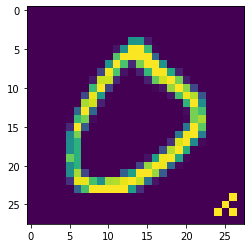

Prediction: 1


In [25]:
# Display image, label, and prediction for a poisoned image to see the backdoor working

c = 1 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(poison_y_test,1) == c)[0][i] # index of the image in poison arrays

plt.imshow(poison_x_test[c_idx].squeeze())
plt.show()
poison_label = c
print("Prediction: " + str(poison_preds[c_idx]))


In [26]:
poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))


 Effectiveness of poison: 86.58%


In [27]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(robust_classifier.predict(poison_x_test), axis=1)
ct=0
for i in range(len(poison_preds)):
  jhc=(poison_preds[i]+1)%10
  if poison_y_test[i][jhc]==1:
    ct+=1
print(ct)
print(len(poison_preds))

60
1110


In [28]:
print(100*ct/len(poison_preds)," % accuracy")

5.405405405405405  % accuracy


In [29]:
poison_x_test = x_test[is_poison_test==0]
poison_y_test = y_test[is_poison_test==0]

poison_preds = np.argmax(robust_classifier.predict(poison_x_test), axis=1)
ct=0
for i in range(len(poison_preds)):
  jhc=(poison_preds[i])%10
  if poison_y_test[i][jhc]==1:
    ct+=1
print(ct)

9667


In [30]:
print(len(poison_preds))
print(100*ct/len(poison_preds)," % accuracy")

10000
96.67  % accuracy
